<a href="https://colab.research.google.com/github/yusufozkuttas/DSA210/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================
# 1) Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set_context("talk")


In [ ]:
# =========================
# 2) PART B — Load & Clean 3 Datasets (GPR + Bitcoin + Gold)
# =========================
import pandas as pd
import numpy as np

def read_any(path_local, github_raw_url=None, **kwargs):
    """Try reading from local path first; if it fails and github_raw_url is provided, read from GitHub raw."""
    try:
        if path_local.lower().endswith(('.xls', '.xlsx')):
            return pd.read_excel(path_local, **kwargs)
        return pd.read_csv(path_local, **kwargs)
    except Exception as e:
        if github_raw_url is None:
            raise
        print(f"Local read failed for {path_local} -> trying GitHub raw...")
        if github_raw_url.lower().endswith(('.xls', '.xlsx')):
            return pd.read_excel(github_raw_url, **kwargs)
        return pd.read_csv(github_raw_url, **kwargs)

# ===========================================================
# A) GPR (Geopolitical Risk) — Excel (.xls)
# ===========================================================
GPR_PATH_LOCAL = "data_gpr_export.xls"
GPR_PATH_GITHUB = None

df_gpr_raw = read_any(GPR_PATH_LOCAL, GPR_PATH_GITHUB)


df_gpr = df_gpr_raw.copy()


possible_date_cols = [c for c in df_gpr.columns if str(c).lower() in ["date", "dates", "time", "month", "timestamp"]]
if possible_date_cols:
    date_col = possible_date_cols[0]
else:

    date_col = df_gpr.columns[0]

df_gpr[date_col] = pd.to_datetime(df_gpr[date_col], errors="coerce")
df_gpr = df_gpr.dropna(subset=[date_col]).sort_values(date_col)
df_gpr = df_gpr.rename(columns={date_col: "Date"})

rename_map = {}
for c in df_gpr.columns:
    lc = str(c).strip().lower()
    if lc in ["gpr", "gpr index", "geopolitical risk"]: rename_map[c] = "GPR"
    if lc in ["gprh", "gpr_h", "gpr high", "gpr headline"]: rename_map[c] = "GPRH"
    if lc in ["gprt", "gpr_t", "gpr threats"]: rename_map[c] = "GPRT"
df_gpr = df_gpr.rename(columns=rename_map)


keep_gpr_cols = [c for c in ["Date", "GPR", "GPRH", "GPRT"] if c in df_gpr.columns]
df_gpr = df_gpr[keep_gpr_cols].copy()

for c in ["GPR", "GPRH", "GPRT"]:
    if c in df_gpr.columns:
        df_gpr[c] = pd.to_numeric(df_gpr[c], errors="coerce")

df_gpr = df_gpr.drop_duplicates(subset=["Date"]).set_index("Date").sort_index()

df_gpr = df_gpr.asfreq('B').ffill()

print("GPR cleaned:", df_gpr.shape, "columns:", list(df_gpr.columns))

# ===========================================================
# B) Bitcoin Prices — CSV
# ===========================================================

BTC_PATH_LOCAL = "Bitcoin History.csv"
BTC_PATH_GITHUB = None

df_btc_raw = read_any(BTC_PATH_LOCAL, BTC_PATH_GITHUB)

df_btc = df_btc_raw.copy()

btc_date_candidates = [c for c in df_btc.columns if str(c).lower() in ["date", "time", "timestamp"]]
btc_date_col = btc_date_candidates[0] if btc_date_candidates else df_btc.columns[0]
df_btc[btc_date_col] = pd.to_datetime(df_btc[btc_date_col], errors="coerce")
df_btc = df_btc.dropna(subset=[btc_date_col]).sort_values(btc_date_col)
df_btc = df_btc.rename(columns={btc_date_col: "Date"}).set_index("Date")


price_candidates = [c for c in df_btc.columns if str(c).lower() in ["adj close", "adj_close", "close", "price"]]
btc_price_col = price_candidates[0] if price_candidates else df_btc.columns[-1]
df_btc[btc_price_col] = pd.to_numeric(df_btc[btc_price_col], errors="coerce")
df_btc = df_btc[[btc_price_col]].rename(columns={btc_price_col: "BTC_Price"}).dropna()


df_btc["btc_return"] = np.log(df_btc["BTC_Price"]).diff()
df_btc = df_btc.asfreq('B').ffill()

print("BTC cleaned:", df_btc.shape)

# ===========================================================
# C) Gold Prices — CSV
# ===========================================================
GOLD_PATH_LOCAL = "goldstock v2.csv"
GOLD_PATH_GITHUB = None

df_gold_raw = read_any(GOLD_PATH_LOCAL, GOLD_PATH_GITHUB)

df_gold = df_gold_raw.copy()

gold_date_candidates = [c for c in df_gold.columns if str(c).lower() in ["date", "time", "timestamp"]]
gold_date_col = gold_date_candidates[0] if gold_date_candidates else df_gold.columns[0]
df_gold[gold_date_col] = pd.to_datetime(df_gold[gold_date_col], errors="coerce")
df_gold = df_gold.dropna(subset=[gold_date_col]).sort_values(gold_date_col)
df_gold = df_gold.rename(columns={gold_date_col: "Date"}).set_index("Date")

gold_price_candidates = [c for c in df_gold.columns if str(c).lower() in ["adj close", "adj_close", "close", "price"]]
gold_price_col = gold_price_candidates[0] if gold_price_candidates else df_gold.columns[-1]
df_gold[gold_price_col] = pd.to_numeric(df_gold[gold_price_col], errors="coerce")
df_gold = df_gold[[gold_price_col]].rename(columns={gold_price_col: "Gold_Price"}).dropna()

df_gold["gold_return"] = np.log(df_gold["Gold_Price"]).diff()
df_gold = df_gold.asfreq('B').ffill()

print("Gold cleaned:", df_gold.shape)

# ===========================================================
# D) Merge & Feature Engineering (create ONE modeling table)
# ===========================================================
df = df_gpr.join(df_btc[["btc_return"]], how="inner").join(df_gold[["gold_return"]], how="inner")
df.columns = df.columns.map(lambda x: str(x).strip())
print(df.columns.tolist())

df = df.dropna()

base_gpr_col = "GPR" if "GPR" in df.columns else df.columns[0]

df["GPR_LAG1"] = df[base_gpr_col].shift(1)
df["GPR_LAG3"] = df[base_gpr_col].shift(3)
df["GPR_ROLL3"] = df[base_gpr_col].rolling(3).mean()

df = df.dropna()

print("Final merged dataset:", df.shape)
df.head()


GPR cleaned: (32786, 3) columns: ['GPR', 'GPRH', 'GPRT']
BTC cleaned: (1745, 2)
Gold cleaned: (2608, 2)
['GPR', 'GPRH', 'GPRT', 'btc_return', 'gold_return']
Final merged dataset: (706, 8)


,GPR,GPRH,GPRT,btc_return,gold_return,GPR_LAG1,GPR_LAG3,GPR_ROLL3
Date,,,,,,,,
2014-07-11,138.753952,104.568336,162.715103,0.023177,0.007219,138.753952,138.753952,138.753952
2014-07-14,138.753952,104.568336,162.715103,-0.015566,-0.024576,138.753952,138.753952,138.753952
2014-07-15,138.753952,104.568336,162.715103,0.002100,-0.007399,138.753952,138.753952,138.753952
2014-07-16,138.753952,104.568336,162.715103,-0.007777,0.000696,138.753952,138.753952,138.753952
2014-07-17,138.753952,104.568336,162.715103,0.019011,0.003550,138.753952,138.753952,138.753952


In [ ]:
# =========================
# 2.5) Modeling Table Setup (Features + Targets)
# =========================
y_btc = df['btc_return']
y_gold = df['gold_return']

X = df.drop(columns=['btc_return','gold_return'])

print('Feature columns:', list(X.columns))
print('X shape:', X.shape)


Feature columns: ['GPR', 'GPRH', 'GPRT', 'GPR_LAG1', 'GPR_LAG3', 'GPR_ROLL3']
X shape: (706, 6)


In [ ]:
# =========================
# 3) Time-aware Train/Test split
# =========================
split = int(len(df) * 0.7)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_btc_train, y_btc_test = y_btc.iloc[:split], y_btc.iloc[split:]
y_gold_train, y_gold_test = y_gold.iloc[:split], y_gold.iloc[split:]

print("Train size:", len(X_train), "| Test size:", len(X_test))


Train size: 494 | Test size: 212


In [ ]:
# =========================
# 4) Standardization
# =========================
scaler_btc = StandardScaler()
X_train_scaled = scaler_btc.fit_transform(X_train)
X_test_scaled = scaler_btc.transform(X_test)


In [ ]:
# =========================
# 5) Model definitions
# =========================
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )
}


In [ ]:
# =========================
# Helper: Train & evaluate
# =========================
def train_and_evaluate(target_name, y_train, y_test):
    rows = []
    trained = {}
    preds = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2 = float(r2_score(y_test, y_pred))

        rows.append({"Asset": target_name, "Model": name, "RMSE": rmse, "R2": r2})
        trained[name] = model
        preds[name] = y_pred
    return pd.DataFrame(rows), trained, preds

results_btc, trained_btc, preds_btc = train_and_evaluate("Bitcoin", y_btc_train, y_btc_test)
results_gold, trained_gold, preds_gold = train_and_evaluate("Gold", y_gold_train, y_gold_test)

results = pd.concat([results_btc, results_gold], ignore_index=True)
results


,Asset,Model,RMSE,R2
0,Bitcoin,Linear Regression,0.028832,-0.010027
1,Bitcoin,Ridge Regression,0.028773,-0.005911
2,Bitcoin,Random Forest,0.029257,-0.040025
3,Gold,Linear Regression,0.008524,-0.018515
4,Gold,Ridge Regression,0.008498,-0.012304
5,Gold,Random Forest,0.008760,-0.075544


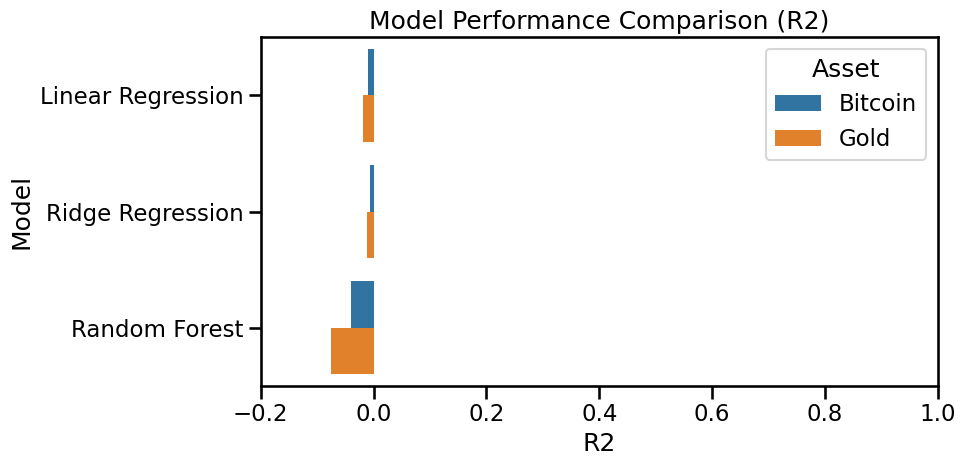

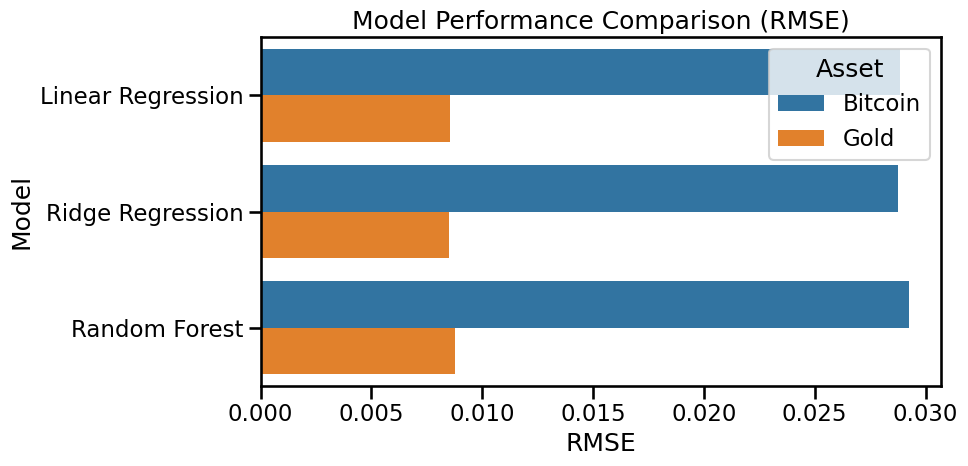

In [ ]:
# =========================
# 6) Performance comparison (R2)
# =========================
plt.figure(figsize=(10, 5))
sns.barplot(data=results, x="R2", y="Model", hue="Asset")
plt.title("Model Performance Comparison (R2)")
plt.xlim(-0.2, 1.0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=results, x="RMSE", y="Model", hue="Asset")
plt.title("Model Performance Comparison (RMSE)")
plt.tight_layout()
plt.show()


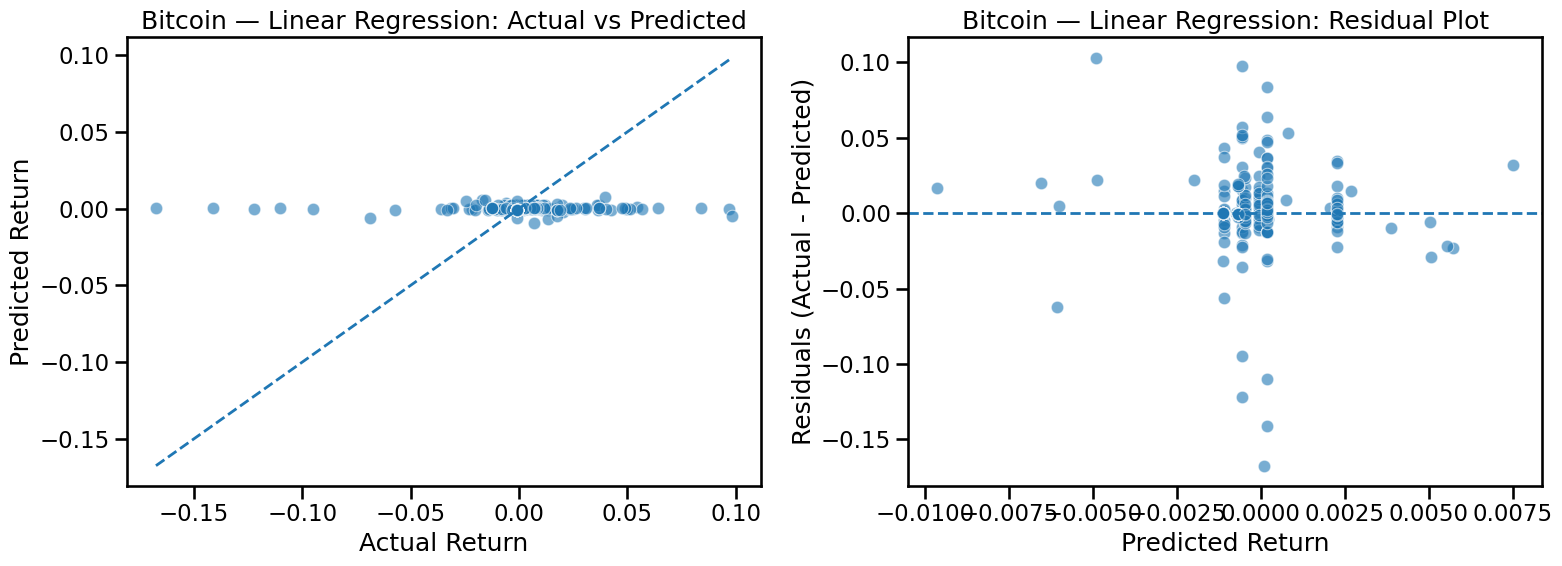

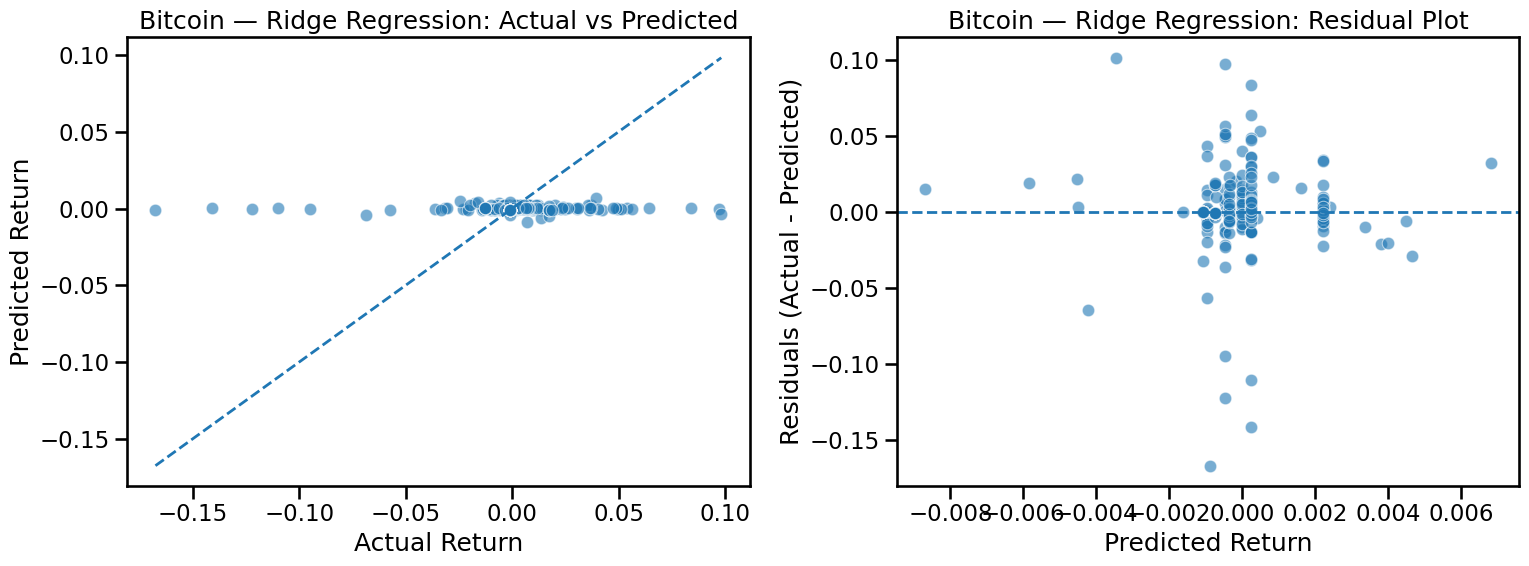

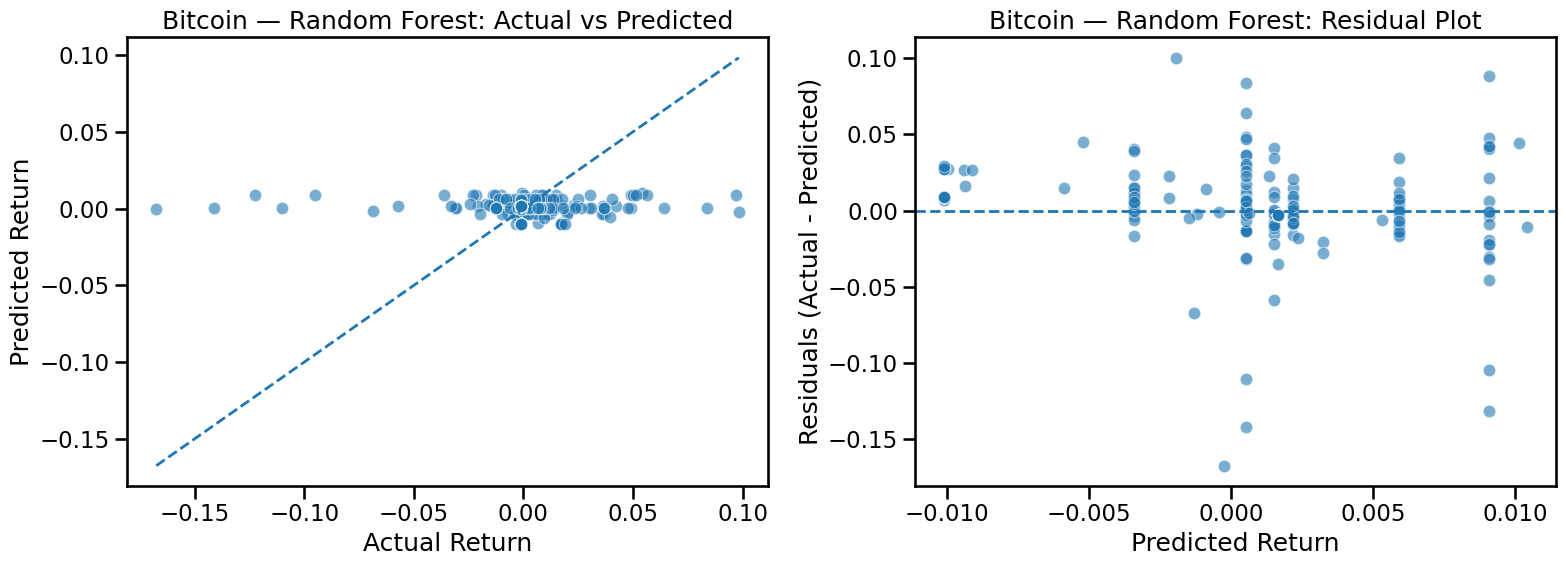

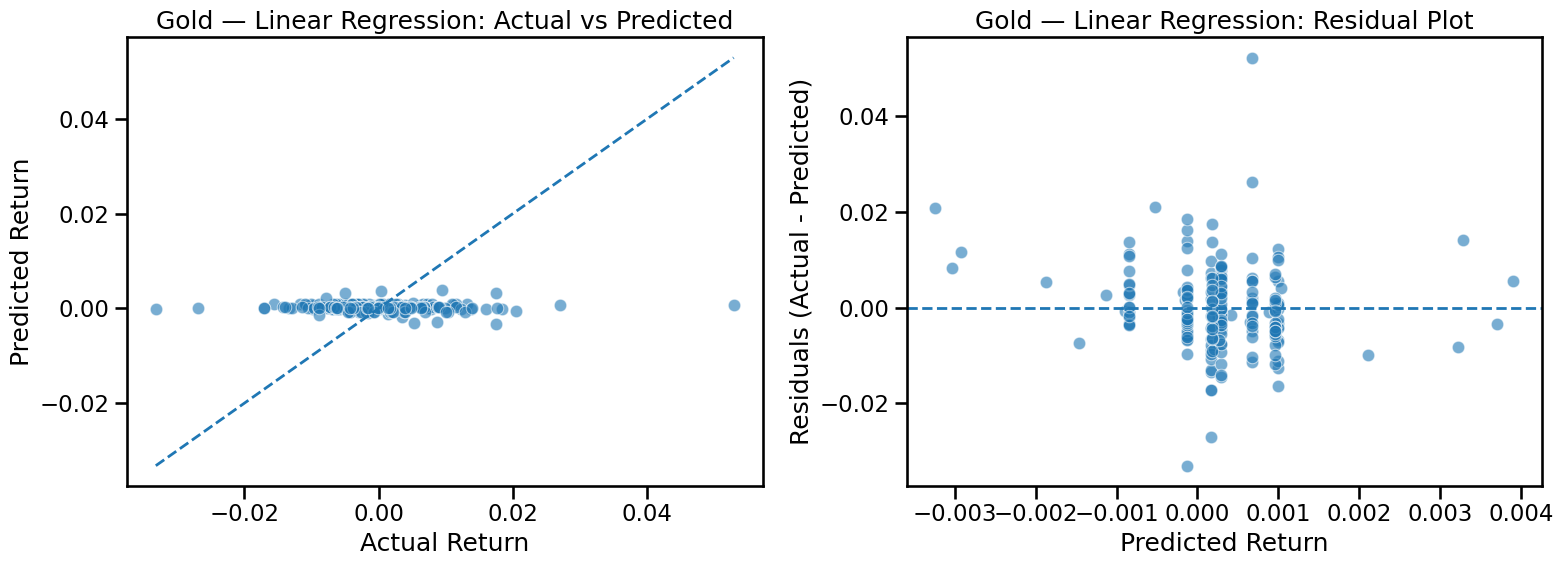

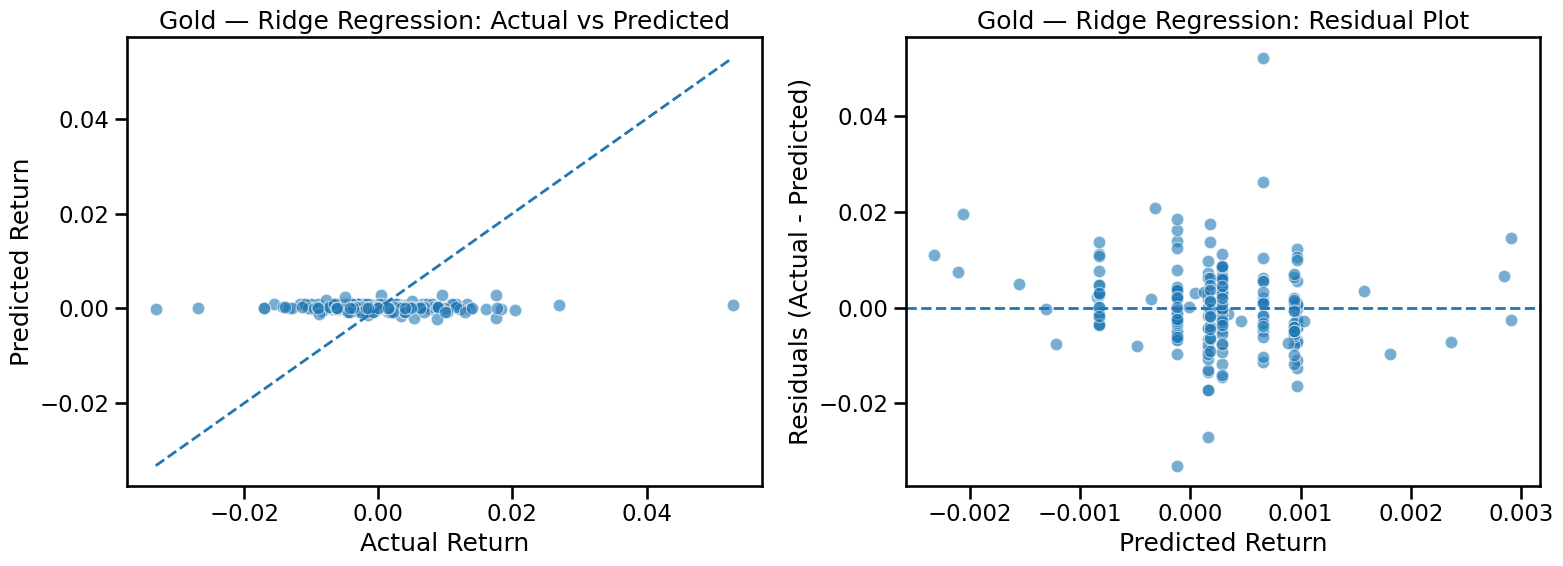

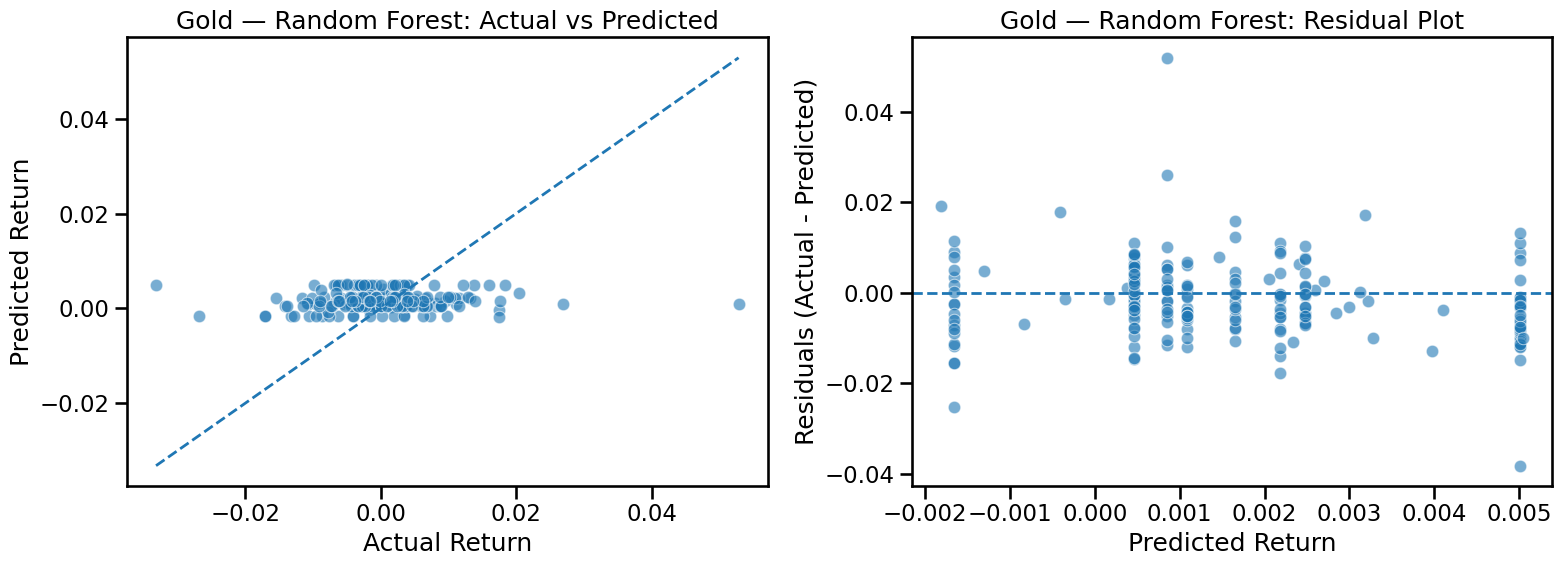

In [ ]:
# =========================
# 7) Diagnostic plots (Actual vs Predicted + Residuals)
# =========================
def plot_performance(model_name, y_true, y_pred, asset_name):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))


    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, ax=axes[0])
    min_val, max_val = min(float(y_true.min()), float(np.min(y_pred))), max(float(y_true.max()), float(np.max(y_pred)))
    axes[0].plot([min_val, max_val], [min_val, max_val], linestyle="--", linewidth=2)
    axes[0].set_title(f"{asset_name} — {model_name}: Actual vs Predicted")
    axes[0].set_xlabel("Actual Return")
    axes[0].set_ylabel("Predicted Return")


    residuals = y_true - y_pred
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, ax=axes[1])
    axes[1].axhline(0, linestyle="--", linewidth=2)
    axes[1].set_title(f"{asset_name} — {model_name}: Residual Plot")
    axes[1].set_xlabel("Predicted Return")
    axes[1].set_ylabel("Residuals (Actual - Predicted)")

    plt.tight_layout()
    plt.show()


for name, y_pred in preds_btc.items():
    plot_performance(name, y_btc_test.reset_index(drop=True), pd.Series(y_pred), "Bitcoin")


for name, y_pred in preds_gold.items():
    plot_performance(name, y_gold_test.reset_index(drop=True), pd.Series(y_pred), "Gold")


In [ ]:
# =========================
# 8) Feature importance (Random Forest)
# =========================
def plot_rf_importance(trained_model, feature_names, title):
    importances = pd.Series(
        trained_model.feature_importances_,
        index=feature_names
    ).sort_values()

    plt.figure(figsize=(10, 6))
    importances.plot(kind="barh")
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()



In [ ]:
# =========================
# 9) Scenario prediction helper (HIGH GPR)
# =========================

def predict_high_gpr_scenario(model, scaler, feature_names, gpr, gprh=None, gprt=None):
    """
    Builds a 1-row input with the same feature columns used in training,
    fills GPR-related columns if they exist, scales with the given scaler,
    and returns the model prediction.
    """
    if gprh is None: gprh = gpr
    if gprt is None: gprt = gpr

    input_df = pd.DataFrame([{col: 0.0 for col in feature_names}])

    fill_map = {
        "GPR": gpr,
        "GPRH": gprh,
        "GPRT": gprt,
        "GPR_LAG1": gpr,
        "GPR_LAG3": gpr,
        "GPR_ROLL3": gpr,
        "GPRH_LAG1": gprh,
        "GPRT_LAG1": gprt,
        "GPRH_ROLL3": gprh,
        "GPRT_ROLL3": gprt,
    }

    for col, val in fill_map.items():
        if col in input_df.columns:
            input_df[col] = float(val)

    input_scaled = scaler.transform(input_df)
    return float(model.predict(input_scaled)[0])


# =========================
# Example usage (Bitcoin)
# =========================
pred_btc = predict_high_gpr_scenario(
    model=trained_btc["Random Forest"],
    scaler=scaler_btc,
    feature_names=list(X.columns),
    gpr=float(df_btc["GPR"].quantile(0.9)) if "GPR" in df_btc.columns else float(df["GPR"].quantile(0.9)),
    gprh=float(df_btc["GPRH"].quantile(0.9)) if "GPRH" in df_btc.columns else None,
    gprt=float(df_btc["GPRT"].quantile(0.9)) if "GPRT" in df_btc.columns else None,
)
print("BTC high GPR prediction:", pred_btc)



BTC high GPR prediction: -0.0010592658984845361


In [ ]:
results.to_csv("part3_model_results.csv", index=False)
print("Saved: part3_model_results.csv")

Saved: part3_model_results.csv
